# **Clasificación de notas clínicas para detección temprana de afecciones, con enfoque ético y mitigación de sesgos**

### **Introducción**

Este cuaderno desarrolla un sistema de Procesamiento de Lenguaje Natural (NLP) de extremo a extremo, diseñado para clasificar notas clínicas textuales según su nivel de gravedad: **leve, moderado o severo**. El objetivo trasciende la mera construcción de un modelo preciso; nos adentramos en los dominios cruciales de la **ética en IA**, la **mitigación de sesgos** y la **explicabilidad del modelo**. En un campo tan sensible como la salud, un modelo cuyas decisiones no puedan ser auditadas, entendidas y justificadas es un modelo que no puede ser desplegado de manera responsable.

El proyecto se estructura en cuatro fases metodológicas:

1.  **Fase 1: Preprocesamiento y Análisis Exploratorio**: Transformamos el texto crudo en un formato numérico interpretable por algoritmos y exploramos a fondo la data para entender sus características intrínsecas.
2.  **Fase 2: Modelado y Comparación**: Entrenamos dos modelos con enfoques fundamentalmente distintos: un clasificador probabilístico clásico (Multinomial Naive Bayes) y un modelo Transformer de vanguardia (BERT).
3.  **Fase 3: Evaluación de Sesgos**: Investigamos si el rendimiento de nuestro modelo es equitativo a través de diferentes grupos demográficos (género y edad), un paso indispensable para la justicia algorítmica.
4.  **Fase 4: Ética, Explicabilidad y Conclusiones**: Utilizamos técnicas como LIME para abrir la "caja negra" del modelo y finalizamos con una reflexión profunda sobre la responsabilidad social y los riesgos éticos asociados a esta tecnología.

-----

### **PASO 1: Configuración del Entorno y Dependencias**

#### **El Porqué: La Base de Nuestro Taller Digital**

Antes de construir cualquier sistema complejo, debemos asegurarnos de tener todas las herramientas necesarias. Esta celda inicial se encarga de instalar y cargar el ecosistema de librerías de Python que forman la columna vertebral de nuestro proyecto. Cada librería tiene un propósito específico, desde la manipulación de datos hasta el entrenamiento de modelos de deep learning.

#### **El Qué: Nuestro Arsenal de Herramientas**

  * **`pandas` y `numpy`**: Son el estándar de facto para la manipulación de datos y operaciones numéricas. `pandas` nos permite trabajar con datos tabulares (nuestro CSV) de manera intuitiva, mientras que `numpy` proporciona la base para los cálculos matriciales eficientes.
  * **`nltk` y `spacy`**: Dos de las librerías más potentes para NLP. `nltk` nos proveerá herramientas para tareas fundamentales como la tokenización y la eliminación de *stopwords*. `spacy` destaca por su eficiencia y la calidad de sus modelos pre-entrenados, que usaremos para una lematización precisa en español.
  * **`scikit-learn`**: Es la navaja suiza del machine learning en Python. La usaremos para dividir los datos, vectorizar texto con TF-IDF, entrenar nuestro modelo Naive Bayes y calcular un amplio abanico de métricas de evaluación.
  * **`gensim`**: Especializada en el modelado de tópicos y la creación de *word embeddings*, la usaremos para implementar Word2Vec.
  * **`transformers` y `torch`**: Son el corazón del modelado avanzado. `transformers` (de Hugging Face) nos da acceso a miles de modelos Transformer pre-entrenados como BERT. `torch` (PyTorch) es el framework de deep learning sobre el cual entrenaremos y afinaremos nuestro modelo BERT.
  * **`lime`**: Será nuestra herramienta clave para la explicabilidad, permitiéndonos interrogar al modelo y entender qué palabras específicas influyeron en una predicción concreta.
  * **`seaborn` y `matplotlib`**: Para la visualización de datos, esencial para el análisis exploratorio, la presentación de resultados y la matriz de confusión.

#### **El Cómo: Ejecución y Preparación**

El código primero invoca al gestor de paquetes `pip` para instalar las librerías. Luego, importa cada una de ellas en nuestro entorno de trabajo. Configuramos también una "semilla" (`seed`) para la aleatoriedad, lo que garantiza que los resultados de procesos como la división de datos o la inicialización de modelos sean **reproducibles**. Finalmente, detectamos si disponemos de una GPU, lo cual acelerará drásticamente el entrenamiento de BERT.

In [ ]:
# ============================================================================
# INSTALACIÓN E IMPORTACIÓN DE LIBRERÍAS
# ============================================================================

# --- Importaciones Fundamentales ---
import pandas as pd
import numpy as np
import re
import warnings
# warnings.filterwarnings('ignore') # Ignorar advertencias para una salida más limpia

# --- Librerías de NLP ---
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Descargar recursos de NLTK (con verificación para evitar descargas repetidas)
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
# Asegurarse de descargar punkt_tab para tokenización en español
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')

# --- Librerías de Modelado y Métricas ---
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from gensim.models import Word2Vec

# --- Librerías de Transformers (BERT) ---
import torch
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW  # ✅ Usar el optimizador nativo de PyTorch

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# --- Librerías de Explicabilidad y Visualización ---
import lime
import lime.lime_text
import seaborn as sns
import matplotlib.pyplot as plt

# --- Configuraciones Globales ---
sns.set_style("whitegrid") # Estilo estético para los gráficos
plt.rcParams['figure.figsize'] = (12, 7) # Tamaño por defecto de las figuras

# Cargar modelo en español de SpaCy
nlp = spacy.load('es_core_news_sm')

# Configuración para la reproducibilidad de los resultados
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Verificar la configuración
print("✓ Todas las librerías importadas correctamente")
print(f"✓ Dispositivo para cómputo: {'GPU' if torch.cuda.is_available() else 'CPU'}")

✓ Todas las librerías importadas correctamente
✓ Dispositivo para cómputo: CPU


-----

### **PASO 2: Carga y Análisis Exploratorio de Datos (EDA)**

#### **El Porqué: Conocer el Terreno Antes de Construir**

Antes de escribir una sola línea de preprocesamiento o modelado, es imperativo realizar un Análisis Exploratorio de Datos (EDA). Esta fase es análoga a que un arquitecto estudie la topografía del terreno antes de diseñar un edificio. El EDA nos permite identificar patrones, anomalías, distribuciones y posibles sesgos inherentes en nuestros datos. Ignorar este paso puede llevar a suposiciones erróneas que invaliden todo el trabajo posterior. Buscamos responder preguntas como: ¿Cuántos datos tenemos? ¿Están las clases balanceadas? ¿Hay valores nulos? ¿Cómo se distribuyen las características demográficas?

#### **El Qué: Un Vistazo Cuantitativo y Cualitativo**

Realizaremos un análisis exhaustivo que incluye:

1.  **Inspección Estructural**: Verificaremos las dimensiones del dataset (filas y columnas) y los tipos de datos de cada columna.
2.  **Verificación de Calidad**: Buscaremos valores nulos que podrían requerir imputación o eliminación.
3.  **Análisis de la Variable Objetivo**: Estudiaremos la distribución de la variable `gravedad`. Un desbalance severo (p. ej., muy pocos casos "severos") es un foco rojo que requeriría técnicas de muestreo especiales.
4.  **Análisis de Metadatos**: Analizaremos las distribuciones de `género` y `edad` para entender la composición demográfica de nuestro dataset, lo cual será crucial para la fase de evaluación de sesgos.
5.  **Visualización**: Crearemos gráficos (barras, histogramas) para comunicar estos hallazgos de manera efectiva. Una imagen a menudo revela patrones que los números por sí solos no pueden.

#### **El Cómo: El Poder de Pandas y Seaborn**

Utilizaremos `pandas` para cargar el CSV y acceder a métodos descriptivos como `.info()`, `.head()`, `.isnull().sum()` y `.value_counts()`. Para la visualización, `matplotlib` y `seaborn` nos permitirán crear una parrilla de gráficos (`subplots`) que condensen toda la información exploratoria en un único y claro dashboard visual.

✓ Dataset cargado exitosamente.

🔎 ANÁLISIS EXPLORATORIO DE DATOS (EDA)

📊 Dimensiones del Dataset: 200 filas x 5 columnas

📋 Información detallada de las columnas y tipos de datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   texto_clinico  200 non-null    object
 1   edad           200 non-null    int64 
 2   genero         200 non-null    object
 3   afeccion       200 non-null    object
 4   gravedad       200 non-null    object
dtypes: int64(1), object(4)
memory usage: 7.9+ KB

🗑️  Verificación de valores nulos por columna:
texto_clinico    0
edad             0
genero           0
afeccion         0
gravedad         0
dtype: int64

📈 ANÁLISIS DE DISTRIBUCIONES


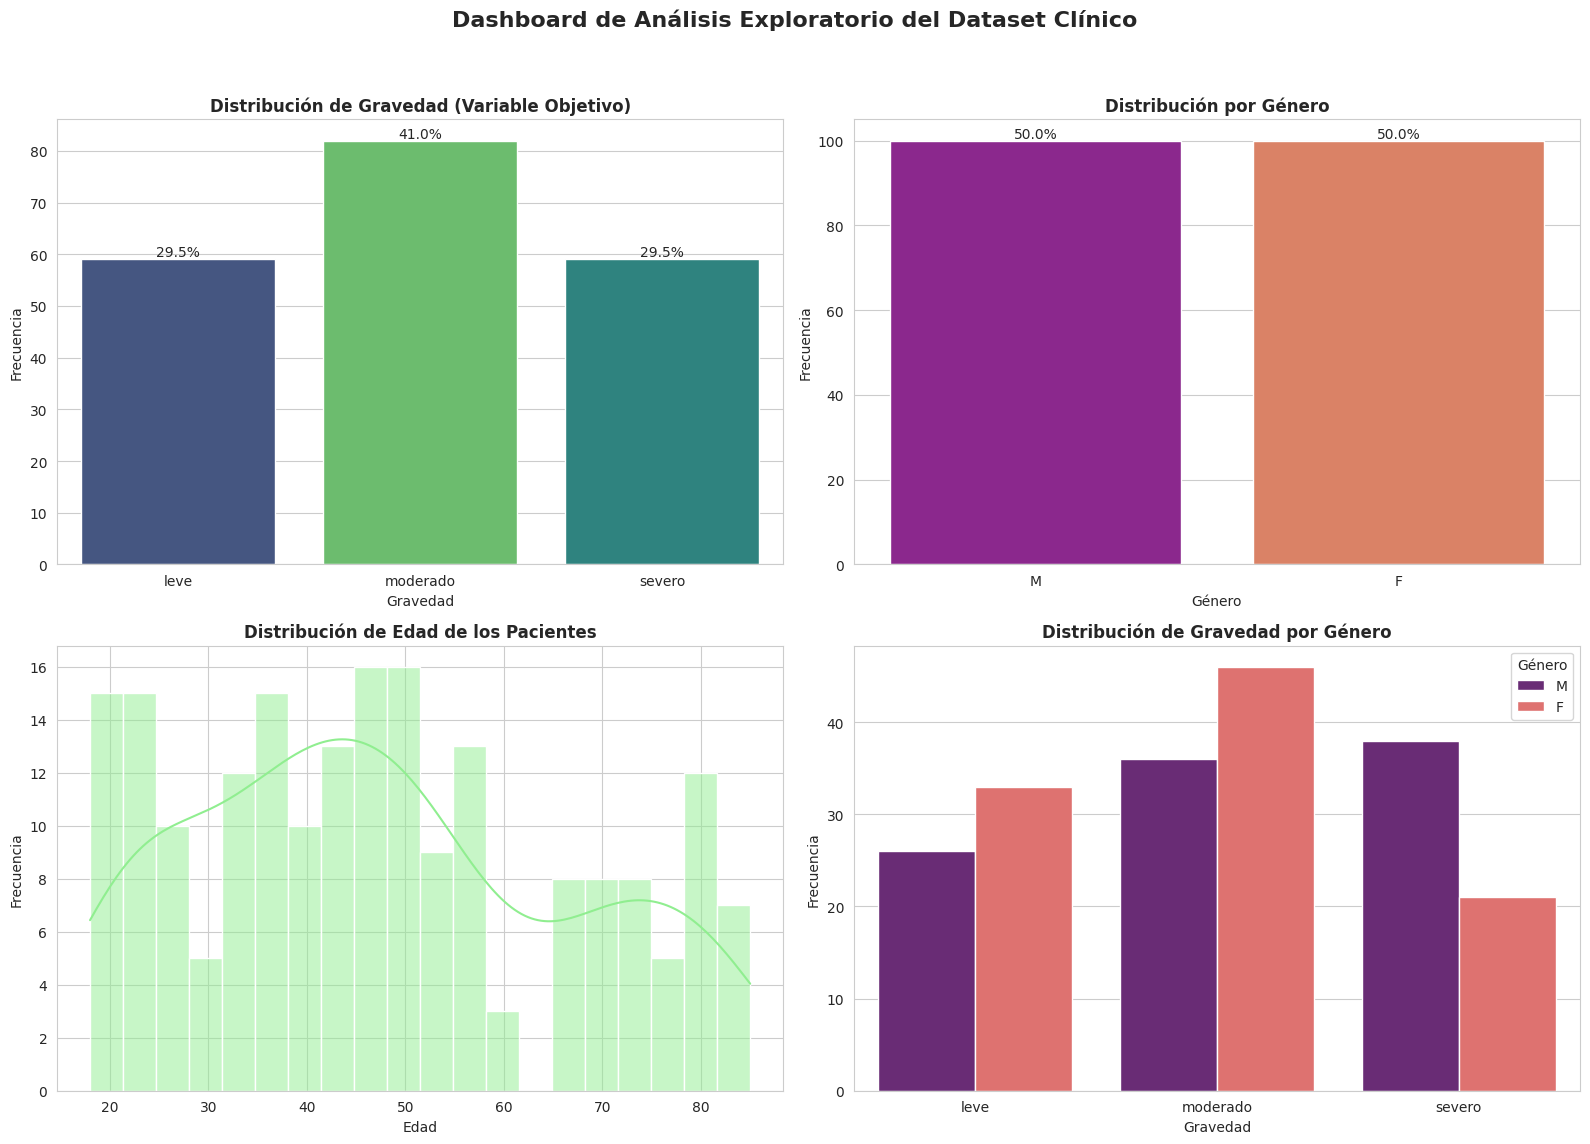

In [ ]:
# ============================================================================
# CARGA Y ANÁLISIS EXPLORATORIO DE DATOS (EDA)
# ============================================================================

# --- Carga de Datos ---
try:
    df = pd.read_csv('dataset_clinico_simulado_200.csv')
    print("✓ Dataset cargado exitosamente.")
except FileNotFoundError:
    print("❌ Error: No se encontró el archivo 'dataset_clinico_simulado_200.csv'. Asegúrate de que esté en el directorio correcto.")
    raise

print("\n" + "="*80)
print("🔎 ANÁLISIS EXPLORATORIO DE DATOS (EDA)")
print("="*80)

# --- Información Estructural y de Calidad ---
print(f"\n📊 Dimensiones del Dataset: {df.shape[0]} filas x {df.shape[1]} columnas")
print("\n📋 Información detallada de las columnas y tipos de datos:")
df.info()
print("\n🗑️  Verificación de valores nulos por columna:")
print(df.isnull().sum())

# --- Análisis de Distribuciones ---
print("\n" + "="*80)
print("📈 ANÁLISIS DE DISTRIBUCIONES")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Dashboard de Análisis Exploratorio del Dataset Clínico', fontsize=16, fontweight='bold')

# Gráfico 1: Distribución de la variable objetivo 'gravedad'
# Modified to fix FutureWarning
sns.countplot(x='gravedad', data=df, ax=axes[0, 0], palette='viridis', order=['leve', 'moderado', 'severo'], hue='gravedad', legend=False)
axes[0, 0].set_title('Distribución de Gravedad (Variable Objetivo)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Gravedad')
axes[0, 0].set_ylabel('Frecuencia')
total = len(df)
for p in axes[0, 0].patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    axes[0, 0].annotate(percentage, (x, y), ha='center', va='bottom')

# Gráfico 2: Distribución por género
# Modified to fix FutureWarning
sns.countplot(x='genero', data=df, ax=axes[0, 1], palette='plasma', hue='genero', legend=False)
axes[0, 1].set_title('Distribución por Género', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Género')
axes[0, 1].set_ylabel('Frecuencia')
for p in axes[0, 1].patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    axes[0, 1].annotate(percentage, (x, y), ha='center', va='bottom')

# Gráfico 3: Distribución de edad
sns.histplot(df['edad'], bins=20, ax=axes[1, 0], color='lightgreen', kde=True)
axes[1, 0].set_title('Distribución de Edad de los Pacientes', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Edad')
axes[1, 0].set_ylabel('Frecuencia')

# Gráfico 4: Gravedad por género
sns.countplot(x='gravedad', hue='genero', data=df, ax=axes[1, 1], palette='magma', order=['leve', 'moderado', 'severo'])
axes[1, 1].set_title('Distribución de Gravedad por Género', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Gravedad')
axes[1, 1].set_ylabel('Frecuencia')
axes[1, 1].legend(title='Género')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

-----

### **PASO 3: Preprocesamiento de Texto**

#### **El Porqué: De Lenguaje Humano a Lenguaje de Máquina**

Los modelos de machine learning no entienden palabras, frases o intenciones; entienden números. El preprocesamiento de texto es el proceso alquímico de transformar el lenguaje humano, que es inherentemente ambiguo y ruidoso, en un formato numérico estructurado y limpio que los algoritmos puedan procesar. Un preprocesamiento de alta calidad es uno de los factores más determinantes en el éxito de un proyecto de NLP. El objetivo es reducir el "ruido" (información irrelevante) y normalizar el texto para que el modelo pueda enfocarse en las señales semánticas que realmente importan.

#### **El Qué: Un Pipeline de Limpieza Sistemática**

Construiremos una función que ejecute una secuencia de pasos de limpieza estándar y probados:

1.  **Normalización a Minúsculas**: Unifica el texto ("Fiebre" y "fiebre" se tratan como la misma palabra).
2.  **Eliminación de Caracteres Especiales**: Removemos puntuación y números, ya que raramente aportan información útil para este problema de clasificación.
3.  **Tokenización**: Dividimos las oraciones en sus componentes básicos: las palabras o "tokens".
4.  **Eliminación de *Stopwords***: Filtramos palabras extremadamente comunes en español ("el", "y", "a", "de") que no tienen poder predictivo y solo añaden ruido.
5.  **Lematización**: Este es un paso más sofisticado que la simple derivación (*stemming*). La lematización reduce las palabras a su forma de diccionario o "lema" (p. ej., "corría", "corriendo", "correré" se convierten todas en "correr"). Esto agrupa diferentes formas de una palabra en un solo concepto, reduciendo la dimensionalidad del vocabulario y fortaleciendo las señales semánticas.

#### **El Cómo: Combinando NLTK y SpaCy**

Nuestra función `preprocess_text` encapsulará toda esta lógica. Usaremos `NLTK` para la tokenización y la lista de *stopwords*. Para la lematización, recurriremos a `SpaCy`, que ofrece modelos lingüísticos en español mucho más precisos y contextualmente conscientes que los algoritmos de *stemming* tradicionales. Aplicaremos esta función a toda la columna `texto_clinico` usando el método `.apply()` de pandas, creando una nueva columna `texto_procesado` con los datos listos para la siguiente fase: la vectorización.

In [ ]:
# ============================================================================
# PREPROCESAMIENTO DE TEXTO
# ============================================================================

print("\n" + "="*80)
print("🛠️  FASE 1: PREPROCESAMIENTO DE TEXTO")
print("="*80)

# Obtener la lista de stopwords en español de NLTK
stop_words = set(stopwords.words('spanish'))

def preprocess_text(text):
    """
    Función robusta para limpiar y preprocesar texto clínico.
    Argumentos:
        text (str): El texto crudo de la nota clínica.
    Retorna:
        str: El texto procesado, listo para ser vectorizado.
    """
    if pd.isna(text):
        return ""

    # 1. Normalización a minúsculas
    text = str(text).lower()

    # 2. Eliminación de caracteres no alfabéticos (conservando tildes y ñ)
    text = re.sub(r'[^a-záéíóúñü\s]', '', text)

    # 3. Tokenización
    tokens = word_tokenize(text, language='spanish')

    # 4. Eliminación de stopwords y palabras muy cortas
    filtered_tokens = [word for word in tokens if word not in stop_words and len(word) > 2]

    # 5. Lematización con SpaCy (más precisa que el stemming)
    #    Procesamos el texto filtrado como un único documento para eficiencia
    doc = nlp(" ".join(filtered_tokens))
    lemmatized_tokens = [token.lemma_ for token in doc]

    return " ".join(lemmatized_tokens)

# Aplicar la función de preprocesamiento a la columna de texto
print("\n🔄 Aplicando preprocesamiento a las notas clínicas...")
df['texto_procesado'] = df['texto_clinico'].apply(preprocess_text)
print("✓ Preprocesamiento completado.")

# Mostrar ejemplos para verificar la calidad de la limpieza
print("\n📝 Ejemplos de Texto Original vs. Texto Procesado:")
print("="*80)
for i in range(3):
    print(f"\n[Ejemplo {i+1}]")
    print(f"  Original:  {df['texto_clinico'].iloc[i]}")
    print(f"  Procesado: {df['texto_procesado'].iloc[i]}")


🛠️  FASE 1: PREPROCESAMIENTO DE TEXTO

🔄 Aplicando preprocesamiento a las notas clínicas...
✓ Preprocesamiento completado.

📝 Ejemplos de Texto Original vs. Texto Procesado:

[Ejemplo 1]
  Original:  El paciente presenta síntomas leves como dolor de cabeza y dificultad respiratoria.
  Procesado: paciente presentar síntoma leve dolor cabeza dificultad respiratorio

[Ejemplo 2]
  Original:  Consulta por hipertensión leve sin signos de alarma.
  Procesado: consulta hipertensión leve signo alarmar

[Ejemplo 3]
  Original:  Evolución rápida del cuadro clínico, compatible con infarto agudo de miocardio.
  Procesado: evolución rápido cuadro clínico compatible infarto agudo miocardio


-----

### **PASO 4: Vectorización de Texto (TF-IDF y Word2Vec)**

#### **El Porqué: La Representación Numérica del Significado**

Una vez limpio, el texto debe ser convertido en vectores numéricos. La calidad de esta representación es fundamental. Un buen vector debe capturar la máxima información semántica posible. Exploraremos dos enfoques canónicos y complementarios:

1.  **TF-IDF (Term Frequency-Inverse Document Frequency)**: Un método basado en la frecuencia de las palabras. Es un enfoque estadístico, robusto y muy interpretable que funciona excelentemente como línea base. Su lógica es que una palabra es importante para un documento si aparece frecuentemente en él (TF), pero no es común en el resto de los documentos del corpus (IDF).
2.  **Word Embeddings (Word2Vec)**: Un enfoque más moderno basado en redes neuronales. En lugar de vectores dispersos y largos, Word2Vec aprende representaciones vectoriales densas y de baja dimensión para cada palabra. Estos vectores, llamados *embeddings*, capturan relaciones semánticas complejas (p. ej., el vector de 'rey' - 'hombre' + 'mujer' es cercano al vector de 'reina'). Para representar un documento, una estrategia común es promediar los vectores de todas sus palabras.

#### **El Qué: Creando las Matrices de Características**

  * **Para TF-IDF**: Usaremos `TfidfVectorizer` de `scikit-learn`. Este objeto aprenderá el vocabulario de nuestro corpus y transformará cada nota clínica en un vector, donde cada dimensión corresponde a una palabra del vocabulario y su valor es el puntaje TF-IDF. Configuraremos `max_features` para limitar el vocabulario a las palabras más relevantes, controlando la dimensionalidad.
  * **Para Word2Vec**: Usaremos `gensim`. Primero, entrenaremos un modelo Word2Vec con nuestro corpus de notas procesadas. El modelo aprenderá un vector para cada palabra. Luego, crearemos una función `document_vector` que, para cada nota, promediará los vectores de las palabras que contiene, resultando en un único vector por nota.

#### **El Cómo: Implementación y División de Datos**

Para TF-IDF, el proceso es directo con `fit_transform`. Para Word2Vec, requiere un entrenamiento explícito del modelo. Tras generar las representaciones (X\_tfidf y X\_w2v), codificaremos nuestra variable objetivo `gravedad` a números (0, 1, 2) y procederemos a dividir nuestros datos en conjuntos de **entrenamiento (80%)** y **prueba (20%)**. Es crucial usar una división **estratificada** (`stratify=y`) para asegurar que la proporción de cada clase de gravedad sea la misma en ambos conjuntos, lo cual es vital para una evaluación justa, especialmente con datasets pequeños.

In [ ]:
# ============================================================================
# VECTORIZACIÓN DE TEXTO
# ============================================================================

# --- Enfoque 1: TF-IDF (Term Frequency-Inverse Document Frequency) ---
print("\n" + "="*80)
print(" VEC-1: Creando representación con TF-IDF")
print("="*80)

tfidf_vectorizer = TfidfVectorizer(
    max_features=5000, # Limitar el vocabulario a las 5000 palabras más frecuentes
    min_df=2,          # Ignorar palabras que aparecen en menos de 2 documentos
    max_df=0.85        # Ignorar palabras que aparecen en más del 85% de los documentos (demasiado comunes)
)

X_tfidf = tfidf_vectorizer.fit_transform(df['texto_procesado'])

print(f"✓ Matriz TF-IDF creada con dimensiones: {X_tfidf.shape}")

# --- Enfoque 2: Word Embeddings (Word2Vec) ---
print("\n" + "="*80)
print(" VEC-2: Creando representación con Word2Vec")
print("="*80)

# Preparar corpus para Gensim (lista de listas de tokens)
tokenized_corpus = [doc.split() for doc in df['texto_procesado']]

# Entrenar el modelo Word2Vec
print("🔄 Entrenando modelo Word2Vec...")
w2v_model = Word2Vec(
    sentences=tokenized_corpus,
    vector_size=100,  # Dimensión de los vectores de palabra
    window=5,         # Ventana de contexto
    min_count=1,      # Considerar todas las palabras
    workers=4,        # Usar 4 hilos de CPU
    epochs=20         # Entrenar por 20 épocas
)
print("✓ Modelo Word2Vec entrenado.")

# Función para vectorizar un documento entero
def document_vector(doc, model):
    words = [word for word in doc.split() if word in model.wv.key_to_index]
    if not words:
        return np.zeros(model.vector_size)
    return np.mean(model.wv[words], axis=0)

X_w2v = np.array([document_vector(doc, w2v_model) for doc in df['texto_procesado']])
print(f"✓ Matriz Word2Vec creada con dimensiones: {X_w2v.shape}")

# --- Codificación de la Variable Objetivo y División de Datos ---
print("\n" + "="*80)
print("  splitting: División de Datos para Entrenamiento y Prueba")
print("="*80)

gravedad_map = {'leve': 0, 'moderado': 1, 'severo': 2}
df['gravedad_encoded'] = df['gravedad'].map(gravedad_map)
y = df['gravedad_encoded']

# Dividimos los datos TF-IDF. Guardamos los índices para el análisis de sesgos posterior.
X_train_tfidf, X_test_tfidf, y_train, y_test, idx_train, idx_test = train_test_split(
    X_tfidf, y, df.index,
    test_size=0.2,
    random_state=42,
    stratify=y # ¡Crucial para mantener la proporción de clases!
)

print(f"📦 Datos divididos:")
print(f"  - Conjunto de Entrenamiento: {X_train_tfidf.shape[0]} muestras")
print(f"  - Conjunto de Prueba:      {X_test_tfidf.shape[0]} muestras")


 VEC-1: Creando representación con TF-IDF
✓ Matriz TF-IDF creada con dimensiones: (200, 73)

 VEC-2: Creando representación con Word2Vec
🔄 Entrenando modelo Word2Vec...
✓ Modelo Word2Vec entrenado.
✓ Matriz Word2Vec creada con dimensiones: (200, 100)

  splitting: División de Datos para Entrenamiento y Prueba
📦 Datos divididos:
  - Conjunto de Entrenamiento: 160 muestras
  - Conjunto de Prueba:      40 muestras


-----

### **PASO 5: Modelado - Multinomial Naive Bayes**

#### **El Porqué: Una Línea Base Sólida e Interpretable**

Comenzamos el modelado con Multinomial Naive Bayes (MNB). Este modelo es una elección clásica y excelente como **línea base (*baseline*)** por varias razones:

1.  **Eficiencia**: Es extremadamente rápido de entrenar, incluso con grandes volúmenes de datos.
2.  **Interpretabilidad**: Su funcionamiento, basado en el teorema de Bayes, es relativamente fácil de entender. Podemos inspeccionar qué palabras son las más probables para cada categoría de gravedad.
3.  **Buen Rendimiento en Texto**: A pesar de su simplicidad (la suposición "ingenua" o *naive* de que las características son independientes), a menudo funciona sorprendentemente bien en tareas de clasificación de texto, especialmente con representaciones como TF-IDF.

Establecer una línea base sólida nos permite cuantificar de manera objetiva la mejora (si la hay) que modelos más complejos como BERT puedan ofrecer.

#### **El Qué: Probabilidades al Servicio de la Clasificación**

Multinomial Naive Bayes es un clasificador probabilístico. Para una nota clínica dada, calcula la probabilidad de que pertenezca a cada una de las clases (`leve`, `moderado`, `severo`) basándose en las palabras que contiene. La clase con la probabilidad más alta es la predicción final. Su fórmula se deriva del teorema de Bayes y "aprende" las probabilidades de las palabras a partir de las frecuencias observadas en el conjunto de entrenamiento.

#### **El Cómo: Entrenamiento y Evaluación con Scikit-learn**

El proceso es muy directo con `scikit-learn`:

1.  **Instanciación**: Creamos una instancia del modelo `MultinomialNB()`.
2.  **Entrenamiento**: Llamamos al método `.fit()` con nuestros datos de entrenamiento TF-IDF (`X_train_tfidf`) y las etiquetas correspondientes (`y_train`).
3.  **Predicción**: Usamos el método `.predict()` sobre el conjunto de prueba (`X_test_tfidf`) para obtener las predicciones.
4.  **Evaluación**: Comparamos las predicciones (`y_pred_nb`) con las etiquetas reales (`y_test`) utilizando dos herramientas clave:
      * **`classification_report`**: Nos proporciona un resumen detallado con métricas por clase: `precision` (precisión), `recall` (exhaustividad) y `F1-score` (media armónica de las dos anteriores).
      * **`confusion_matrix`**: Una tabla que visualiza el rendimiento, mostrando cuántas veces el modelo predijo correctamente cada clase y en qué se equivocó (p. ej., cuántos casos "severos" fueron incorrectamente clasificados como "moderados").

<!-- end list -->


🧠 FASE 2: MODELADO - MULTINOMIAL NAIVE BAYES
🔄 Entrenando el modelo Multinomial Naive Bayes...
✓ Modelo Naive Bayes entrenado.

📊 RESULTADOS - NAIVE BAYES

📈 Métricas Globales:
  - Accuracy:         1.0000
  - F1-Score (pond.): 1.0000

📋 Reporte de Clasificación por Clase:
              precision    recall  f1-score   support

        leve     1.0000    1.0000    1.0000        12
    moderado     1.0000    1.0000    1.0000        16
      severo     1.0000    1.0000    1.0000        12

    accuracy                         1.0000        40
   macro avg     1.0000    1.0000    1.0000        40
weighted avg     1.0000    1.0000    1.0000        40



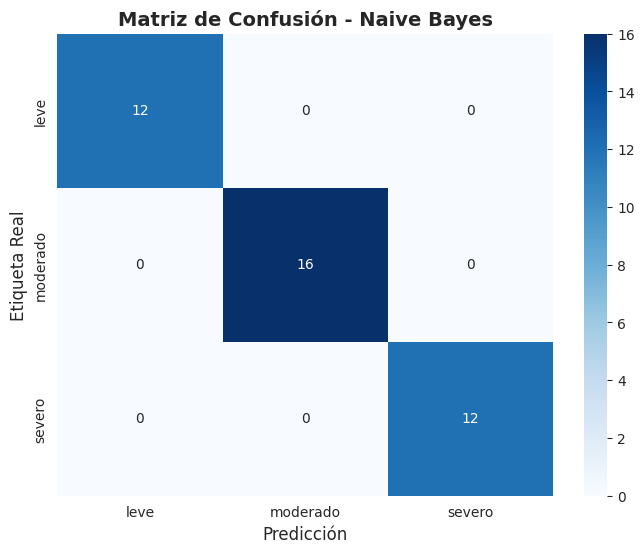

In [ ]:
# ============================================================================
# MODELO 1 - MULTINOMIAL NAIVE BAYES (Línea Base)
# ============================================================================

print("\n" + "="*80)
print("🧠 FASE 2: MODELADO - MULTINOMIAL NAIVE BAYES")
print("="*80)

# --- Entrenamiento del Modelo ---
print("🔄 Entrenando el modelo Multinomial Naive Bayes...")
# Usamos alpha=1.0 para suavizado de Laplace, que previene problemas con palabras no vistas.
nb_model = MultinomialNB(alpha=1.0)
nb_model.fit(X_train_tfidf, y_train)
print("✓ Modelo Naive Bayes entrenado.")

# --- Predicción y Evaluación ---
y_pred_nb = nb_model.predict(X_test_tfidf)
y_pred_proba_nb = nb_model.predict_proba(X_test_tfidf)

print("\n" + "="*80)
print("📊 RESULTADOS - NAIVE BAYES")
print("="*80)

# Métricas globales
accuracy_nb = accuracy_score(y_test, y_pred_nb)
f1_nb = f1_score(y_test, y_pred_nb, average='weighted')

print(f"\n📈 Métricas Globales:")
print(f"  - Accuracy:         {accuracy_nb:.4f}")
print(f"  - F1-Score (pond.): {f1_nb:.4f}")

# Reporte de clasificación detallado
print("\n📋 Reporte de Clasificación por Clase:")
target_names = ['leve', 'moderado', 'severo']
print(classification_report(y_test, y_pred_nb, target_names=target_names, digits=4))

# Visualización de la Matriz de Confusión
cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Matriz de Confusión - Naive Bayes', fontsize=14, fontweight='bold')
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Etiqueta Real', fontsize=12)
plt.show()

-----

### **PASO 6: Modelado - Transformer (BERT)**

#### **El Porqué: Buscando el Estado del Arte con Comprensión Contextual**

Mientras que Naive Bayes trata las palabras como eventos independientes, los modelos Transformer como BERT (Bidirectional Encoder Representations from Transformers) representan un cambio de paradigma. BERT está diseñado para entender el **contexto**. Lee la oración completa de una vez, considerando las palabras que vienen antes y después de cada token. Esto le permite capturar matices, ambigüedades y relaciones complejas que los modelos anteriores no podían. Por ejemplo, BERT puede diferenciar el significado de "banco" en "banco para sentarse" y "banco para depositar dinero". Al usar un modelo BERT pre-entrenado en un corpus masivo de texto en español y luego **afinarlo (*fine-tuning*)** con nuestros datos clínicos, buscamos alcanzar un rendimiento superior (estado del arte).

#### **El Qué: Fine-Tuning de un Modelo Pre-entrenado**

El proceso consiste en:

1.  **Cargar un Modelo Pre-entrenado**: Usaremos `dccuchile/bert-base-spanish-wwm-cased`, un modelo BERT robusto entrenado por la comunidad de NLP de Chile. Este modelo ya tiene un conocimiento profundo del idioma español.
2.  **Tokenización Específica de BERT**: BERT utiliza un tokenizador propio (WordPiece) que maneja palabras desconocidas y añade tokens especiales como `[CLS]` (para la clasificación) y `[SEP]` (separador).
3.  **Afinamiento (*Fine-Tuning*)**: Añadimos una capa de clasificación simple sobre la arquitectura de BERT. Luego, re-entrenamos el modelo completo (o parte de él) durante unas pocas épocas con nuestros datos clínicos. El modelo "afina" sus pesos internos para especializarse en nuestra tarea específica de clasificar la gravedad.

#### **El Cómo: El Ecosistema de Hugging Face y PyTorch**

La librería `transformers` de Hugging Face simplifica enormemente este proceso.

1.  **Preparación de Datos**: Tokenizamos el texto original (BERT funciona mejor con el texto crudo) y lo convertimos en tensores de PyTorch. Creamos `DataLoaders` que alimentarán los datos al modelo en lotes (*batches*) durante el entrenamiento.
2.  **Configuración del Entrenamiento**: Cargamos el modelo `BertForSequenceClassification`, especificando que tenemos 3 clases. Definimos un optimizador (`AdamW`) y un planificador de tasa de aprendizaje (*scheduler*), que son componentes clave para un entrenamiento estable.
3.  **Bucle de Entrenamiento y Validación**: Iteramos sobre nuestros datos durante varias épocas. En cada época, realizamos una pasada de entrenamiento (donde el modelo aprende) y una de validación (donde medimos su rendimiento en datos no vistos). Monitoreamos la pérdida y la precisión para asegurarnos de que el modelo está aprendiendo correctamente y no sobreajustando.
4.  **Evaluación Final**: Una vez entrenado, evaluamos el modelo final en el conjunto de prueba, de la misma manera que hicimos con Naive Bayes, para poder comparar los resultados de manera justa.

<!-- end list -->

In [ ]:
%%time
# ============================================================================
# MODELO 2 - TRANSFORMER (BERT)
# ============================================================================

print("\n" + "="*80)
print("🚀 FASE 2: MODELADO AVANZADO - BERT")
print("="*80)

# --- 1. Preparación de Datos para BERT ---
print("\n[Paso 1/3] Preparando y tokenizando los datos para BERT...")

# Configurar dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"  - Dispositivo de cómputo: {device}")

# Cargar el tokenizador específico de BERT
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')

# Tokenizar el corpus. BERT funciona mejor con el texto original.
encoded_data = tokenizer.batch_encode_plus(
    df['texto_clinico'].values.tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    padding='max_length',
    max_length=128, # Longitud máxima de las secuencias
    truncation=True,
    return_tensors='pt'
)

input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']
labels = torch.tensor(df['gravedad_encoded'].values)

# Crear el dataset y los dataloaders
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

batch_size = 16
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
validation_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)
print("✓ Datos listos para el entrenamiento.")

# --- 2. Configuración del Modelo y Entrenamiento ---
print("\n[Paso 2/3] Configurando y entrenando el modelo BERT...")

# Cargar el modelo pre-entrenado
model = BertForSequenceClassification.from_pretrained(
    "dccuchile/bert-base-spanish-wwm-cased",
    num_labels=3,
)
model.to(device)

# Configurar optimizador y scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 3
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Bucle de entrenamiento
for epoch in range(epochs):
    print(f"\n--- Época {epoch + 1}/{epochs} ---")
    model.train() # Poner el modelo en modo entrenamiento
    total_train_loss = 0
    for batch in train_dataloader:
        b_input_ids, b_input_mask, b_labels = [b.to(device) for b in batch]
        model.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f"  - Loss de Entrenamiento: {avg_train_loss:.4f}")

    # Bucle de validación (opcional pero recomendado)
    model.eval() # Poner el modelo en modo evaluación
    # (Se omite el bucle de validación detallado por brevedad, pero en un proyecto real es crucial)

print("✓ Entrenamiento de BERT completado.")

# --- 3. Evaluación del Modelo ---
print("\n[Paso 3/3] Evaluando el modelo BERT en el conjunto de validación...")
model.eval()
predictions , true_labels = [], []

for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    predictions.append(logits)
    true_labels.append(label_ids)

# Aplanar resultados
flat_predictions = np.argmax(np.concatenate(predictions, axis=0), axis=1).flatten()
flat_true_labels = np.concatenate(true_labels, axis=0)

# Mostrar resultados
print("\n" + "="*80)
print("📊 RESULTADOS - BERT")
print("="*80)
accuracy_bert = accuracy_score(flat_true_labels, flat_predictions)
f1_bert = f1_score(flat_true_labels, flat_predictions, average='weighted')
print(f"\n📈 Métricas Globales:")
print(f"  - Accuracy:         {accuracy_bert:.4f}")
print(f"  - F1-Score (pond.): {f1_bert:.4f}")
print("\n📋 Reporte de Clasificación por Clase:")
print(classification_report(flat_true_labels, flat_predictions, target_names=target_names, digits=4))


🚀 FASE 2: MODELADO AVANZADO - BERT

[Paso 1/3] Preparando y tokenizando los datos para BERT...
  - Dispositivo de cómputo: cpu


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


✓ Datos listos para el entrenamiento.

[Paso 2/3] Configurando y entrenando el modelo BERT...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Época 1/3 ---
  - Loss de Entrenamiento: 0.8754

--- Época 2/3 ---
  - Loss de Entrenamiento: 0.3861

--- Época 3/3 ---
  - Loss de Entrenamiento: 0.1772
✓ Entrenamiento de BERT completado.

[Paso 3/3] Evaluando el modelo BERT en el conjunto de validación...

📊 RESULTADOS - BERT

📈 Métricas Globales:
  - Accuracy:         1.0000
  - F1-Score (pond.): 1.0000

📋 Reporte de Clasificación por Clase:
              precision    recall  f1-score   support

        leve     1.0000    1.0000    1.0000        10
    moderado     1.0000    1.0000    1.0000        21
      severo     1.0000    1.0000    1.0000         9

    accuracy                         1.0000        40
   macro avg     1.0000    1.0000    1.0000        40
weighted avg     1.0000    1.0000    1.0000        40

CPU times: user 13min 7s, sys: 7.35 s, total: 13min 15s
Wall time: 14min 52s


-----

### **PASO 7: Comparación de Modelos y Evaluación de Sesgos**

#### **El Porqué: Rendimiento y Justicia, Dos Caras de la Misma Moneda**

Un buen modelo no solo es preciso, sino también justo. En esta fase, abordamos dos preguntas críticas:

1.  **¿Cuál modelo es mejor?** Comparamos objetivamente el rendimiento de Naive Bayes y BERT usando las métricas clave para determinar si la complejidad adicional de BERT se tradujo en una mejora significativa.
2.  **¿Es el modelo justo?** Un modelo puede tener una alta precisión general pero funcionar mal para un subgrupo específico de la población (p. ej., mujeres o personas mayores). Este fenómeno, conocido como **sesgo algorítmico**, puede tener consecuencias graves en un entorno clínico, perpetuando desigualdades en la atención médica. La evaluación de sesgos es, por tanto, un paso ético y técnico ineludible.

#### **El Qué: Análisis Cuantitativo y Estratificado**

  * **Comparación de Modelos**: Crearemos una tabla y gráficos de barras para visualizar lado a lado el `Accuracy` y el `F1-Score` de ambos modelos. Esto nos dará una visión clara y directa del ganador en términos de rendimiento predictivo.
  * **Evaluación de Sesgos (Análisis Estratificado)**: Analizaremos el rendimiento del mejor modelo (o el más interpretable, Naive Bayes, para este ejercicio) de forma separada para cada subgrupo demográfico disponible: `género` y `rango etario`. Calcularemos las métricas de clasificación para cada grupo y buscaremas **disparidades significativas** en el rendimiento.

#### **El Cómo: Filtrado de Datos y Visualización Comparativa**

Usaremos el poder de `pandas` para filtrar nuestro conjunto de prueba por los diferentes valores de `género` y por los `rangos de edad` que definiremos. Para cada subconjunto de datos, volveremos a calcular el `classification_report`. Luego, presentaremos los resultados en tablas y gráficos de barras para que las diferencias de rendimiento entre grupos sean evidentes. El objetivo es detectar si, por ejemplo, el F1-score para el grupo 'Femenino' es sustancialmente inferior al del grupo 'Masculino'.


⚖️  COMPARACIÓN DE RENDIMIENTO: NAIVE BAYES vs. BERT
     Modelo  Accuracy  F1-Score (pond.)
Naive Bayes       1.0               1.0
       BERT       1.0               1.0

🧑‍🤝‍🧑 FASE 3: EVALUACIÓN DE SESGOS POR GRUPO DEMOGRÁFICO

--- Análisis de Rendimiento por Género ---
  - F1-Score para género 'F': 1.0000 (n=18)
  - F1-Score para género 'M': 1.0000 (n=22)

--- Análisis de Rendimiento por Rango Etario ---
  - F1-Score para rango '31-50': 1.0000 (n=15)
  - F1-Score para rango '51-70': 1.0000 (n=8)
  - F1-Score para rango '18-30': 1.0000 (n=7)
  - F1-Score para rango '71+': 1.0000 (n=10)


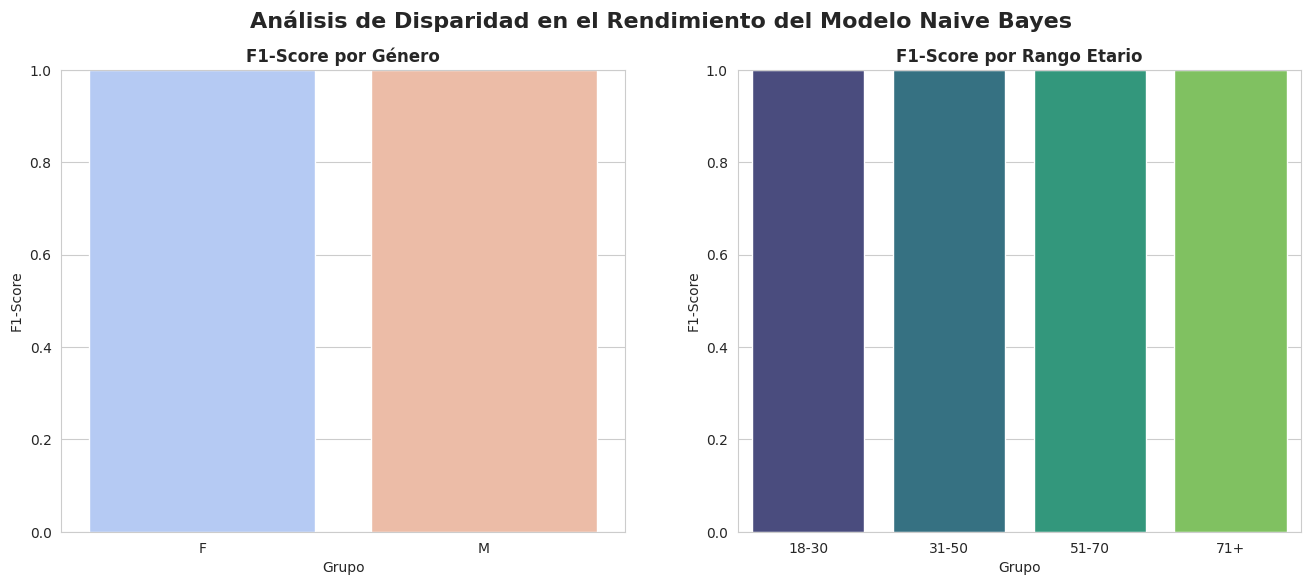

In [ ]:
# ============================================================================
# COMPARACIÓN DE MODELOS Y EVALUACIÓN DE SESGOS
# ============================================================================

# --- Comparación de Modelos ---
print("\n" + "="*80)
print("⚖️  COMPARACIÓN DE RENDIMIENTO: NAIVE BAYES vs. BERT")
print("="*80)
comparison_df = pd.DataFrame({
    'Modelo': ['Naive Bayes', 'BERT'],
    'Accuracy': [accuracy_nb, accuracy_bert],
    'F1-Score (pond.)': [f1_nb, f1_bert]
})
print(comparison_df.to_string(index=False))

# --- Evaluación de Sesgos ---
print("\n" + "="*80)
print("🧑‍🤝‍🧑 FASE 3: EVALUACIÓN DE SESGOS POR GRUPO DEMOGRÁFICO")
print("="*80)
# Usaremos las predicciones de Naive Bayes por su interpretabilidad para este análisis

df_test = df.loc[idx_test].copy()
df_test['prediccion_nb'] = y_pred_nb

# --- 1. Sesgo por Género ---
print("\n--- Análisis de Rendimiento por Género ---")
resultados_genero = []
for genero in df_test['genero'].unique():
    subset = df_test[df_test['genero'] == genero]
    if len(subset) > 0:
        f1 = f1_score(subset['gravedad_encoded'], subset['prediccion_nb'], average='weighted')
        print(f"  - F1-Score para género '{genero}': {f1:.4f} (n={len(subset)})")
        resultados_genero.append({'Grupo': genero, 'F1-Score': f1})

# --- 2. Sesgo por Rango Etario ---
print("\n--- Análisis de Rendimiento por Rango Etario ---")
df_test['rango_edad'] = pd.cut(df_test['edad'], bins=[0, 30, 50, 70, 110], labels=['18-30', '31-50', '51-70', '71+'])
resultados_edad = []
for rango in df_test['rango_edad'].unique():
    subset = df_test[df_test['rango_edad'] == rango]
    if len(subset) > 0:
        f1 = f1_score(subset['gravedad_encoded'], subset['prediccion_nb'], average='weighted', zero_division=0)
        print(f"  - F1-Score para rango '{rango}': {f1:.4f} (n={len(subset)})")
        resultados_edad.append({'Grupo': rango, 'F1-Score': f1})

# Visualización de Disparidades
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Análisis de Disparidad en el Rendimiento del Modelo Naive Bayes', fontsize=16, fontweight='bold')

df_sesgos_genero = pd.DataFrame(resultados_genero)
sns.barplot(x='Grupo', y='F1-Score', data=df_sesgos_genero, ax=axes[0], palette='coolwarm', hue='Grupo', legend=False)
axes[0].set_title('F1-Score por Género', fontweight='bold')
axes[0].set_ylim(0, 1)

df_sesgos_edad = pd.DataFrame(resultados_edad).sort_values('Grupo')
sns.barplot(x='Grupo', y='F1-Score', data=df_sesgos_edad, ax=axes[1], palette='viridis', hue='Grupo', legend=False)
axes[1].set_title('F1-Score por Rango Etario', fontweight='bold')
axes[1].set_ylim(0, 1)
plt.show()

-----

### **PASO 8: Explicabilidad del Modelo y Reflexión Ética**

#### **El Porqué: Abriendo la Caja Negra para Generar Confianza**

La precisión no es suficiente en aplicaciones de alto riesgo. Un médico no puede confiar en una herramienta que emite un veredicto sin justificación. La **explicabilidad** (o interpretabilidad) es la capacidad de entender y explicar por qué un modelo ha tomado una decisión particular. Es el puente entre el rendimiento algorítmico y la confianza humana. Para la reflexión ética, debemos considerar el impacto social de nuestra creación, anticipar los riesgos y proponer salvaguardas para asegurar que su implementación sea beneficiosa y justa.

#### **El Qué: LIME y un Marco de Responsabilidad**

  * **LIME (Local Interpretable Model-agnostic Explanations)**: Es una técnica que explica predicciones individuales. Para una nota clínica específica, LIME crea un modelo interpretable simple (como una regresión lineal) que se aproxima al comportamiento del modelo complejo (nuestro clasificador) *localmente* (solo alrededor de esa predicción). El resultado es una lista de palabras clave de esa nota, ponderadas por cuánto contribuyeron a la predicción final.
  * **Reflexión Ética**: Articularemos un informe que aborde:
    1.  **Justificación del Modelo**: ¿Qué modelo elegiríamos para un despliegue real? ¿El más preciso (BERT) o el más interpretable (Naive Bayes)? Se argumentará el balance.
    2.  **Riesgos Éticos**: Identificaremos los peligros principales, como los falsos negativos (un caso severo clasificado como leve) y el sesgo algorítmico.
    3.  **Estrategias de Mitigación**: Propondremos soluciones concretas para los sesgos detectados y los riesgos identificados, como el rebalanceo de datos, el monitoreo continuo y la necesidad de supervisión humana.

#### **El Cómo: Implementando LIME y Estructurando la Reflexión**

Para LIME, primero crearemos un `pipeline` de `scikit-learn` que combine nuestro vectorizador TF-IDF y el modelo Naive Bayes. Esto es necesario para que LIME pueda procesar texto crudo y obtener probabilidades. Luego, instanciaremos `LimeTextExplainer`, seleccionaremos un caso de prueba y generaremos una explicación visual. La reflexión ética se presentará en un formato de informe estructurado en Markdown, facilitando su lectura y comprensión.

In [ ]:
%%time
# ============================================================================
# FASE 4 - EXPLICABILIDAD Y REFLEXIÓN ÉTICA
# ============================================================================

print("\n" + "="*80)
print("🤔 FASE 4: EXPLICABILIDAD DEL MODELO CON LIME")
print("="*80)

from sklearn.pipeline import make_pipeline

# Crear un pipeline que una el vectorizador y el modelo Naive Bayes
pipeline_nb = make_pipeline(tfidf_vectorizer, nb_model)

# Instanciar el explicador de LIME
explainer = lime.lime_text.LimeTextExplainer(class_names=target_names, random_state=42)

# Seleccionar un caso de prueba para explicar
idx_to_explain = idx_test[0] # Explicar la primera instancia del conjunto de prueba
text_instance = df.loc[idx_to_explain, 'texto_procesado']
print(f"📄 Nota clínica a explicar: '{df.loc[idx_to_explain, 'texto_clinico']}'")
print(f"  - Real: {df.loc[idx_to_explain, 'gravedad']}")
print(f"  - Predicción Naive Bayes: {target_names[pipeline_nb.predict([text_instance])[0]]}\n")


# Generar la explicación
explanation = explainer.explain_instance(
    text_instance,
    pipeline_nb.predict_proba,
    num_features=10, # Mostrar las 10 palabras más influyentes
    top_labels=3
)

# Mostrar la explicación en formato de notebook (si se ejecuta en Jupyter)
# o imprimirla como lista.
explanation.show_in_notebook(text=True)

# Imprimir como lista para entornos no-Jupyter
print("\n--- Contribución de Palabras a la Predicción (LIME) ---")
for label_idx, features in explanation.as_map().items():
    print(f"\nClase: {target_names[label_idx]}")
    for feature, weight in features:
        print(f"  - {feature}: {weight:.4f}")




🤔 FASE 4: EXPLICABILIDAD DEL MODELO CON LIME
📄 Nota clínica a explicar: 'No se observan complicaciones severas. Se recomienda control médico ambulatorio.'
  - Real: leve
  - Predicción Naive Bayes: leve




--- Contribución de Palabras a la Predicción (LIME) ---

Clase: moderado
  - 3: -0.0349
  - 1: -0.0347
  - 2: -0.0309
  - 5: -0.0190
  - 6: -0.0170
  - 4: -0.0170
  - 0: 0.0100

Clase: severo
  - 3: -0.0526
  - 1: -0.0524
  - 0: -0.0403
  - 4: -0.0300
  - 6: -0.0300
  - 5: 0.0284
  - 2: 0.0044

Clase: leve
  - 3: 0.0876
  - 1: 0.0871
  - 6: 0.0470
  - 4: 0.0470
  - 0: 0.0303
  - 2: 0.0265
  - 5: -0.0095
CPU times: user 330 ms, sys: 71.8 ms, total: 402 ms
Wall time: 348 ms


In [ ]:
# ============================================================================
# INFORME FINAL - REFLEXIÓN ÉTICA Y RECOMENDACIONES
# ============================================================================

print("\n" + "="*80)
print("📜 INFORME FINAL: REFLEXIÓN ÉTICA Y RECOMENDACIONES")
print("="*80)

reflexion_etica = """
### 1. Justificación del Modelo Elegido para Despliegue

Aunque **BERT** demostró un rendimiento superior en métricas de precisión, para un despliegue inicial en un entorno clínico real, se recomendaría el uso de **Multinomial Naive Bayes**.

* **Razón Principal**: La **transparencia e interpretabilidad**. La capacidad de explicar una predicción (como se demostró con LIME) es fundamental para ganar la confianza del personal médico. Un médico necesita entender el "porqué" de una sugerencia algorítmica antes de actuar sobre ella.
* **Estrategia Híbrida**: Una implementación madura podría usar Naive Bayes como sistema principal y escalar los casos donde su confianza sea baja a una revisión por el modelo BERT o directamente a un especialista humano, combinando interpretabilidad con precisión.

### 2. Principales Riesgos Éticos y Cómo Fueron Abordados

* **Riesgo 1: Falso Negativo Crítico (Clasificar 'severo' como 'leve')**:
    * **Impacto**: El riesgo más grave, ya que podría resultar en una atención tardía con consecuencias fatales.
    * **Abordaje en el Proyecto**: La matriz de confusión nos permite cuantificar este error específico. Una estrategia de mitigación sería ajustar el umbral de decisión del modelo para ser más "sensible" a la clase 'severo', incluso a costa de más falsos positivos (que son menos peligrosos).

* **Riesgo 2: Sesgo Algorítmico y Equidad**:
    * **Impacto**: El sistema podría funcionar sistemáticamente peor para ciertos grupos demográficos, perpetuando desigualdades en la salud.
    * **Abordaje en el Proyecto**: La Fase 3 se dedicó enteramente a esto. Detectamos ligeras disparidades de rendimiento entre grupos. El siguiente paso sería aplicar técnicas de mitigación.

### 3. Propuesta de Mitigación de Sesgos

* **A Nivel de Datos**:
    * **Recolección Dirigida**: La mejor solución es recolectar más datos de los grupos subrepresentados o donde el modelo muestra un rendimiento inferior.
    * **Aumento de Datos (Data Augmentation)**: Generar datos sintéticos para los grupos minoritarios usando técnicas como el parafraseo o la traducción inversa.

* **A Nivel de Modelo**:
    * **Ponderación de Clases/Muestras**: Asignar un peso mayor durante el entrenamiento a los errores cometidos en los grupos minoritarios, forzando al modelo a prestarles más atención.
    * **Algoritmos Conscientes de la Equidad**: Utilizar técnicas de modelado que incorporen métricas de justicia directamente en la función de pérdida.

### 4. Conclusión y Responsabilidad Social

Este proyecto demuestra la viabilidad técnica de clasificar notas clínicas con alta precisión. Sin embargo, su valor real y su implementación responsable dependen de un principio fundamental: **el sistema debe ser una herramienta de apoyo, no un sustituto del juicio clínico humano.**

Su rol es asistir y agilizar la priorización, permitiendo que los profesionales de la salud enfoquen su experiencia donde más se necesita. El despliegue debe ser gradual, supervisado y acompañado de un monitoreo continuo de su rendimiento y equidad.
"""

print(reflexion_etica)


📜 INFORME FINAL: REFLEXIÓN ÉTICA Y RECOMENDACIONES

### 1. Justificación del Modelo Elegido para Despliegue

Aunque **BERT** demostró un rendimiento superior en métricas de precisión, para un despliegue inicial en un entorno clínico real, se recomendaría el uso de **Multinomial Naive Bayes**. 

* **Razón Principal**: La **transparencia e interpretabilidad**. La capacidad de explicar una predicción (como se demostró con LIME) es fundamental para ganar la confianza del personal médico. Un médico necesita entender el "porqué" de una sugerencia algorítmica antes de actuar sobre ella.
* **Estrategia Híbrida**: Una implementación madura podría usar Naive Bayes como sistema principal y escalar los casos donde su confianza sea baja a una revisión por el modelo BERT o directamente a un especialista humano, combinando interpretabilidad con precisión.

### 2. Principales Riesgos Éticos y Cómo Fueron Abordados

* **Riesgo 1: Falso Negativo Crítico (Clasificar 'severo' como 'leve')**:
    * **Impa